In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Dense,Activation
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from sklearn import metrics


In [2]:
fpath = "./dataset"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:20]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))


List of categories =  ['df', 'real'] 

No. of categories =  2


In [3]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_array = Image.fromarray(img, 'RGB')

            resized_img = img_array.resize((150, 150))

            img_lst.append(np.array(resized_img))

            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))




No. of images loaded =  2000 
No. of labels loaded =  2000
<class 'list'> <class 'list'>


In [4]:

images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))



Images shape =  (2000, 150, 150, 3) 
Labels shape =  (2000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


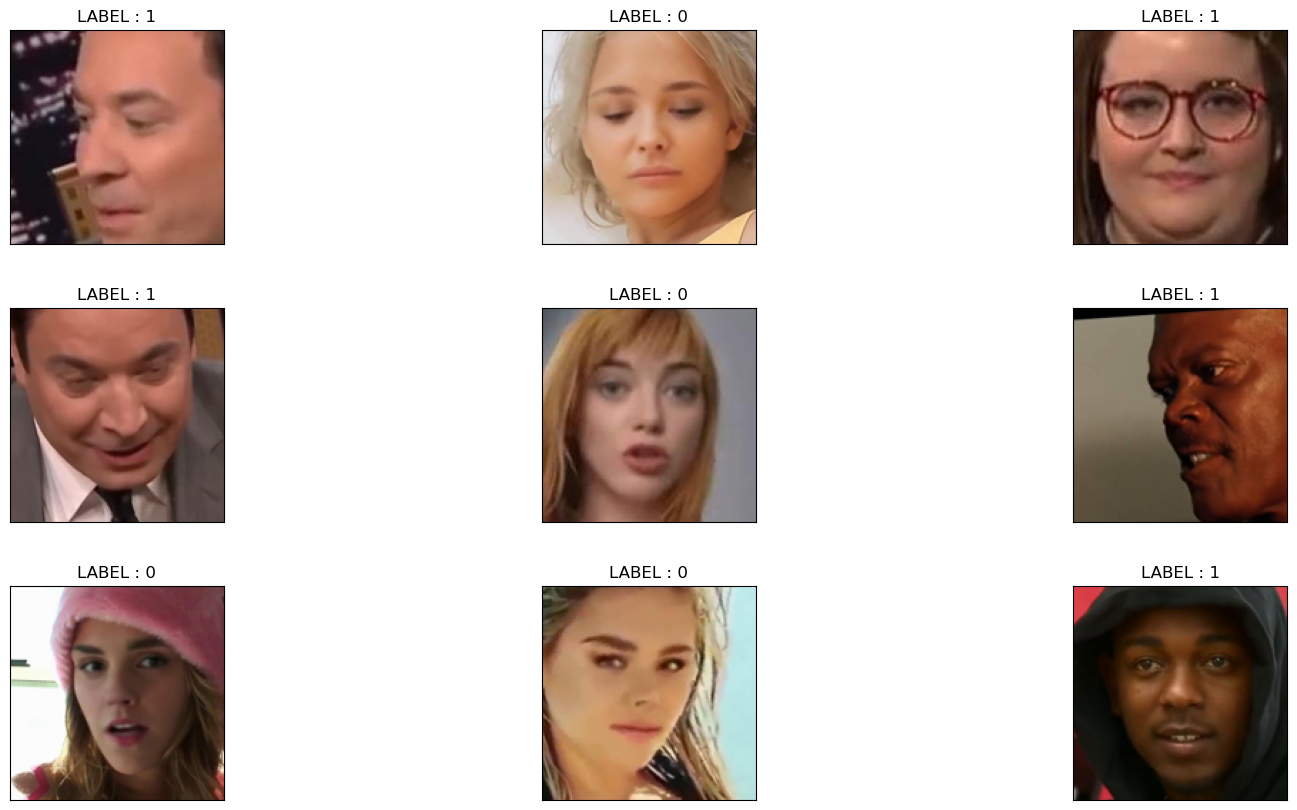

In [5]:

def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0
    for i in range(9):
        n += 1
        r = np.random.randint(0 , images.shape[0] , 1)

        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])

        plt.title('LABEL : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])

    plt.show()

display_rand_images(images, labels)




In [6]:


n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)



'n' values before shuffling =  [   0    1    2 ... 1997 1998 1999]

'n' values after shuffling =  [1860  353 1333 ...  860 1459 1126]


In [7]:

images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)



Images shape after shuffling =  (2000, 150, 150, 3) 
Labels shape after shuffling =  (2000,)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)



x_train shape =  (1600, 150, 150, 3)
y_train shape =  (1600,)

x_test shape =  (400, 150, 150, 3)
y_test shape =  (400,)


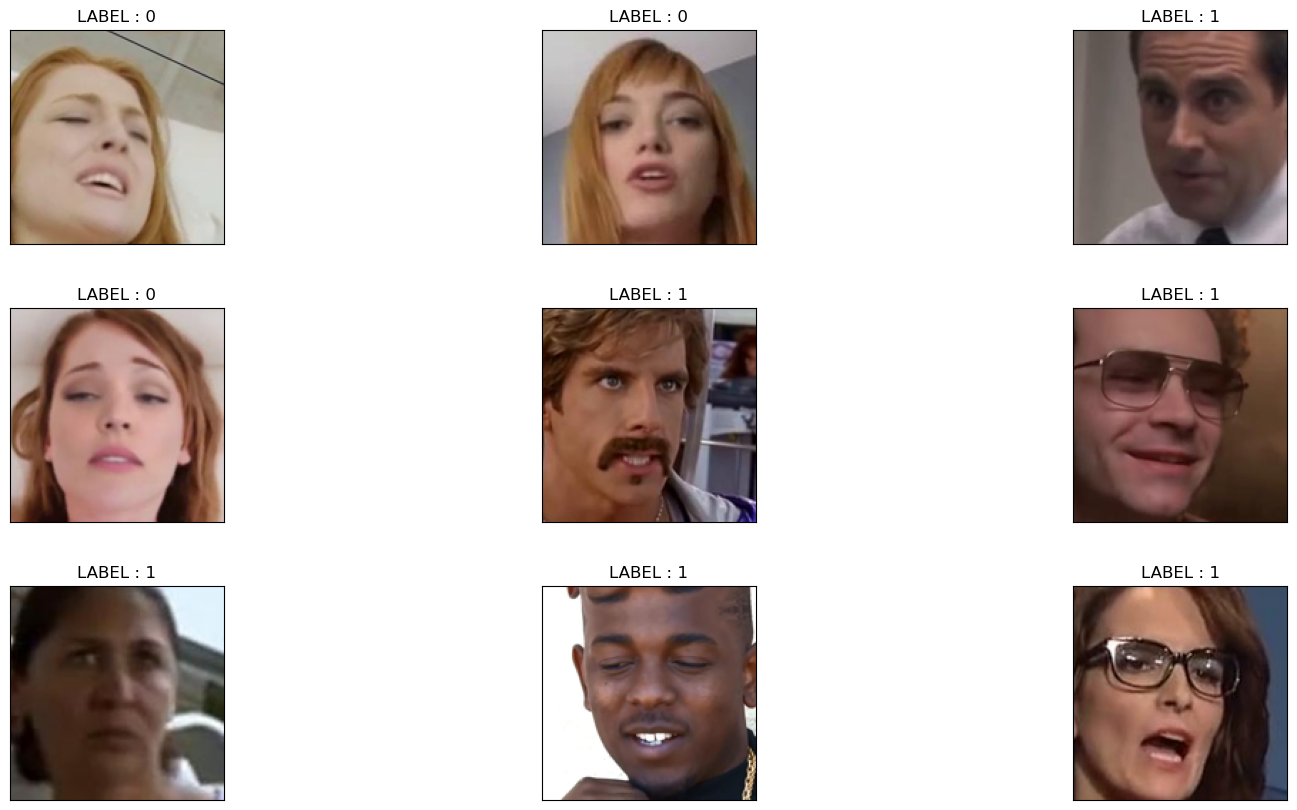

In [9]:
display_rand_images(x_train, y_train)


In [10]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,validation_split = 0.25
 )



In [11]:
train_generator = train_datagen.flow_from_directory(
    fpath,
    target_size = (150,150),
    batch_size = 32,subset = 'training',
     class_mode = 'binary')

Found 1500 images belonging to 2 classes.


In [12]:
validation_generator = train_datagen.flow_from_directory(
    fpath,
    target_size = (150,150),
    batch_size = 32,subset = 'validation',
    class_mode = 'binary',shuffle=False)

Found 500 images belonging to 2 classes.


In [13]:
dense_model = DenseNet121(input_shape=(150,150,3),include_top=False,weights="imagenet")
for layer in dense_model.layers:
    layer.trainable=False
model=Sequential()
model.add(dense_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              33556480  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                     

In [14]:
OPT    = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [15]:
hist = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
)

Epoch 1/10


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8497 - loss: 0.3806 - val_accuracy: 0.8940 - val_loss: 0.5723
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9386 - loss: 0.1431 - val_accuracy: 0.9160 - val_loss: 0.4493
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9630 - loss: 0.1060 - val_accuracy: 0.9200 - val_loss: 0.3312
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9704 - loss: 0.0825 - val_accuracy: 0.9040 - val_loss: 0.3968
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9800 - loss: 0.0622 - val_accuracy: 0.9040 - val_loss: 0.3333
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9793 - loss: 0.0385 - val_accuracy: 0.9360 - val_loss: 0.2710
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9822 - loss: 0.0545 - val_accuracy: 0.9420 - val_loss: 0.2279
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9810 - loss: 0.0491 - val_accuracy: 0.9200 - val_loss: 0.2512
Ep

In [16]:
model.save('model_weights.h5')

ValueError: Unable to synchronously create dataset (name already exists)

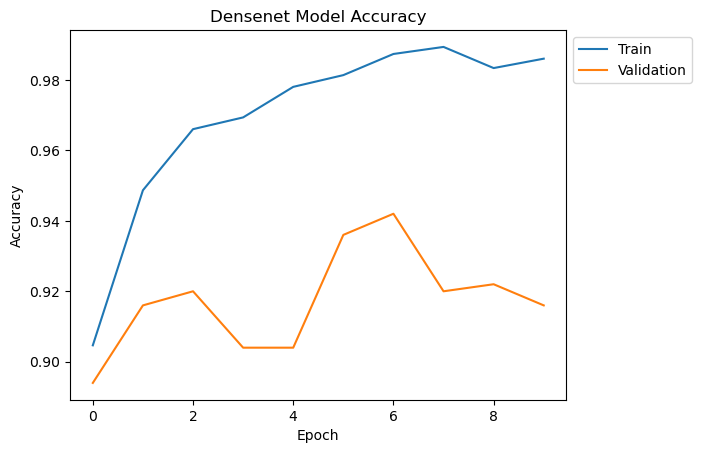

In [17]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

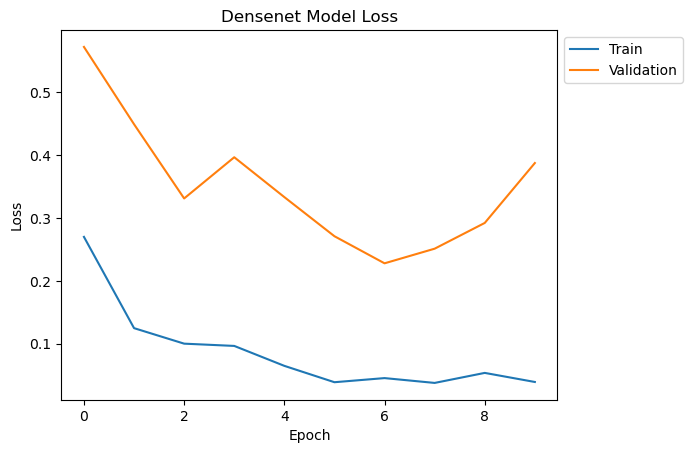

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Densenet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


<Axes: >

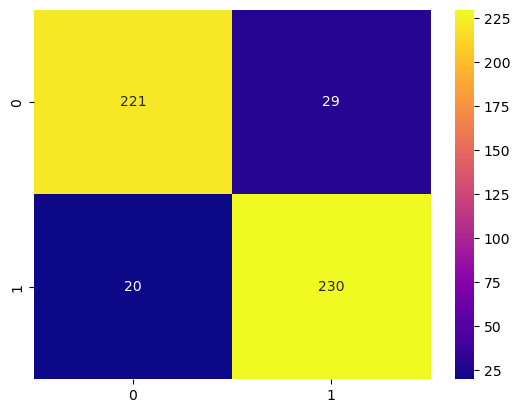

In [19]:

y_true = validation_generator.classes
y_pred = (model.predict(validation_generator) > 0.5).astype("int32")
cm=confusion_matrix(y_true, y_pred)

sns.heatmap(cm,cmap="plasma",fmt="d",annot=True)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,img_to_array
model=load_model('model_weights.h5')
import tensorflow as tf

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 150, 150, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [21]:
def predict(filepth):
    img = load_img(filepth, target_size=(150,150))
    img = img_to_array(img)
    img = img / 255
    plt.imshow(img)
    plt.axis('off')
    img = np.expand_dims(img,axis=0)
    answer = model.predict(img)
    if answer < 0.5:
        print("The image is a deepfake ")
    else:
        print("The image is of a real person ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
The image is a deepfake 


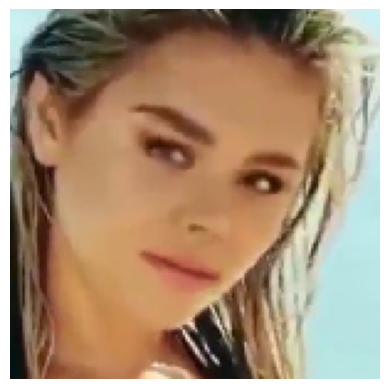

In [25]:
predict("./dataset/df/130_36.jpg")

In [4]:
predict("./dataset/real/36_348.jpg")

NameError: name 'predict' is not defined